In [1]:
import jax
import jax.numpy as jnp
import numpy as np

from specq_jax.data import load_model
from specq_jax.core import (
    X,
    gate_loss,
    calculate_expvals,
    plot_expvals_v2,
    get_simulator,
    # rotating_transmon_hamiltonian,
    optimize,
    gate_fidelity,
    evalulate_model_to_pauli
)
from specq_jax.model import BasicBlackBox
from specq_jax.pulse import MultiDragPulse
from specq_dev.specq.jax import JaxBasedPulseSequence
import specq_dev.specq.shared as specq

import pennylane as qml

In [2]:
def rotating_transmon_hamiltonian(
    qubit_info: specq.QubitInformationV3, signal
):
    a0 = 2 * jnp.pi * qubit_info.frequency
    a1 = 2 * jnp.pi * qubit_info.drive_strength

    f3 = lambda params, t: a1 * signal(params, t)
    f_sigma_x = lambda params, t: f3(params, t) * jnp.cos(a0 * t)
    f_sigma_y = lambda params, t: -1 * f3(params, t) * jnp.sin(a0 * t)   # NOTE: WHY?

    return f_sigma_x * qml.PauliX(0) + f_sigma_y * qml.PauliY(0)

In [3]:
PATH = "ckpts/0020"
DATA_PATH = "../../specq-experiment/datasets/0020"
model_state, restored_history, data_config = load_model(PATH)

pulse_sequence = JaxBasedPulseSequence.from_dict(
    data_config.pulse_sequence,
    [MultiDragPulse] * len(data_config.pulse_sequence["pulses"]),
)

exp_config = specq.ExperimentConfigV3.from_file(DATA_PATH)

t_eval = jnp.linspace(
    0,
    pulse_sequence.pulse_length_dt * exp_config.device_cycle_time_ns,
    pulse_sequence.pulse_length_dt,
)

simulator = get_simulator(
    qubit_info=exp_config.qubits[0],
    t_eval=t_eval,
    hamiltonian=rotating_transmon_hamiltonian,
)

gate_optim_key = jax.random.PRNGKey(0)
model = BasicBlackBox(**model_state.model_config)

/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.12/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable

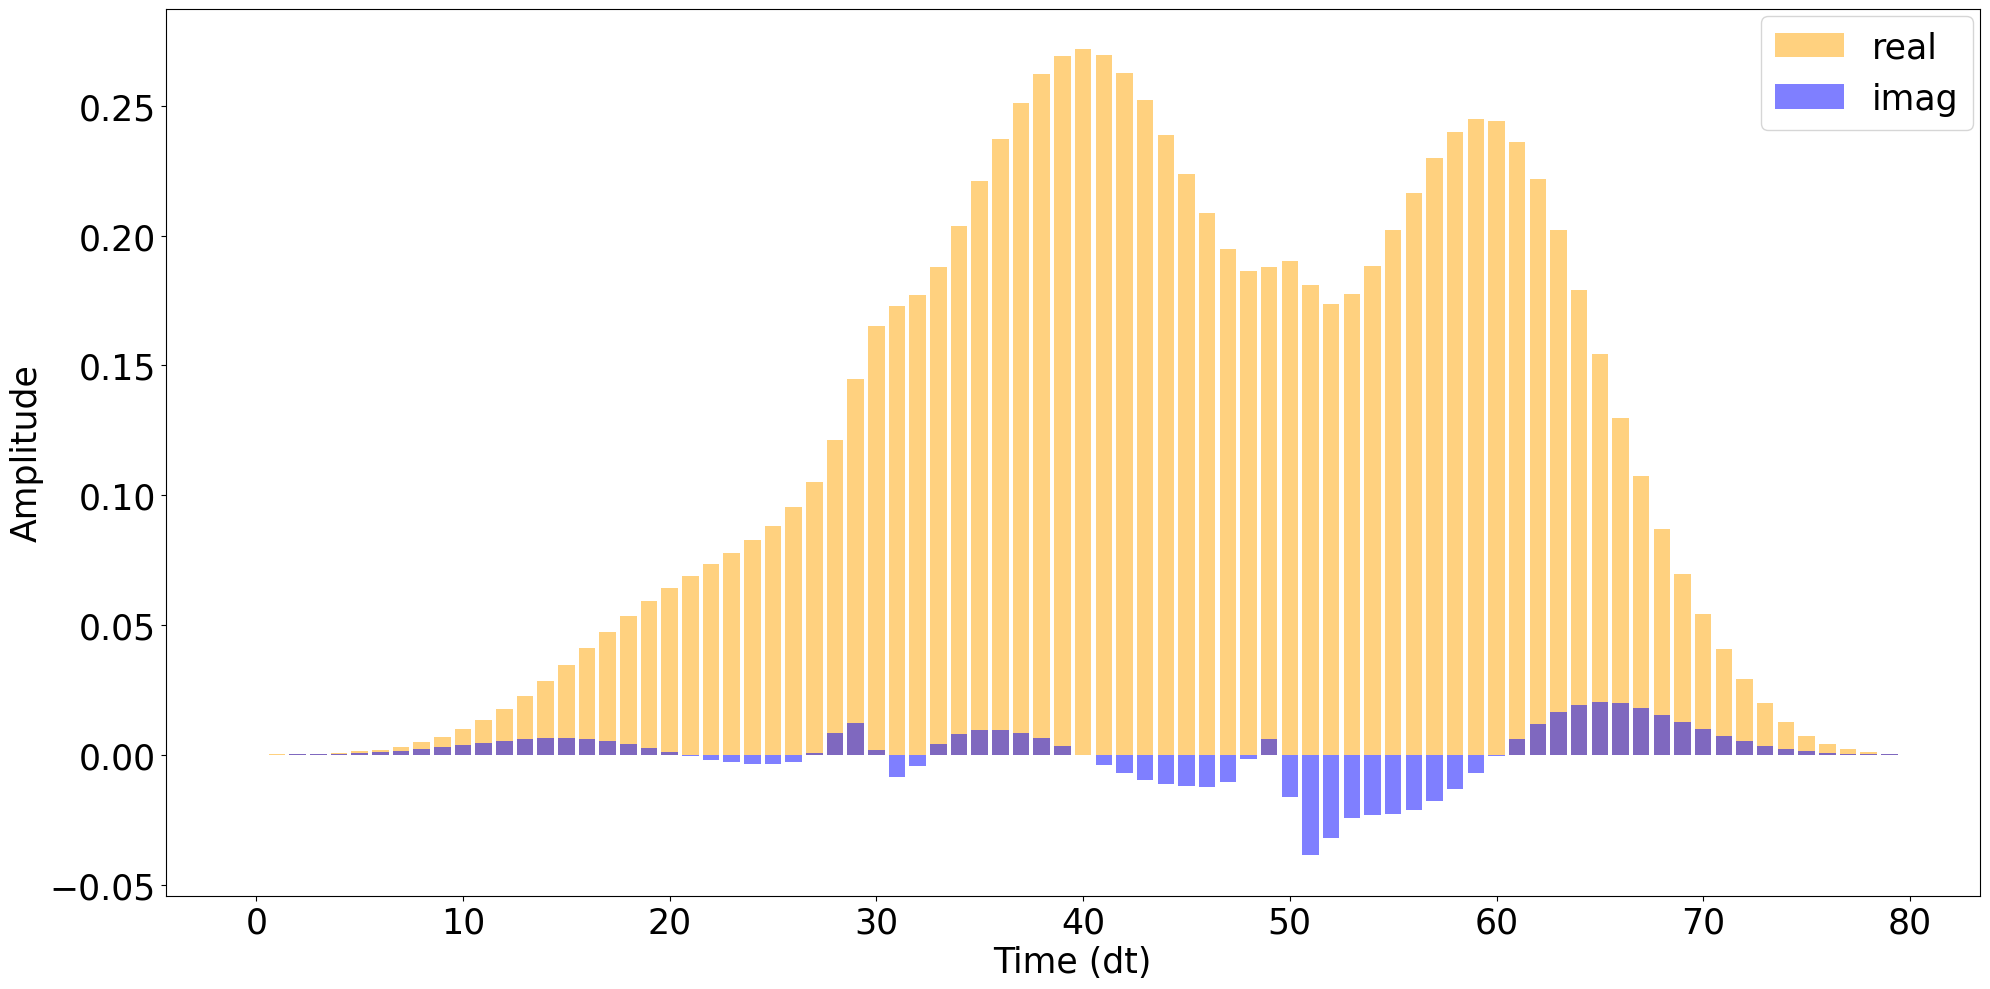

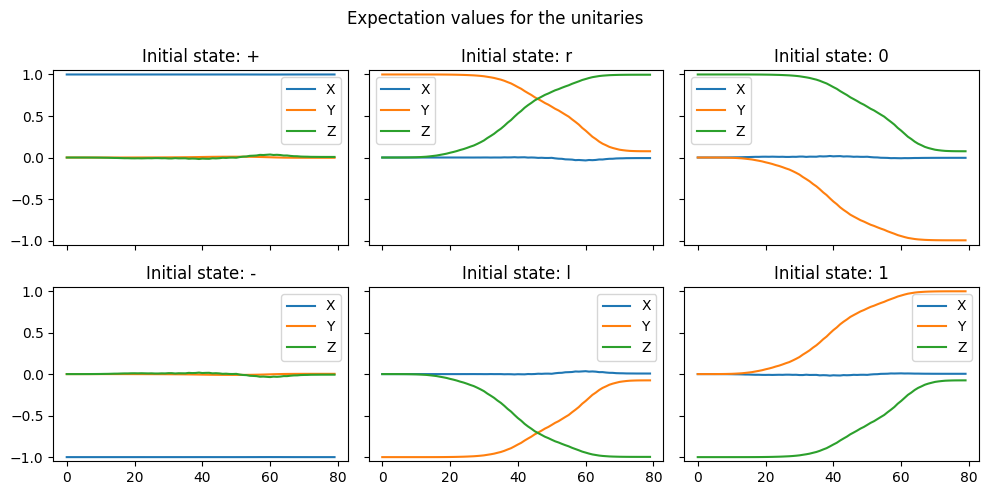

In [4]:
target_unitary = jax.scipy.linalg.sqrtm(X)
fun = lambda x: gate_loss(
    x,
    model,
    model_state.model_params,
    simulator,
    pulse_sequence,
    target_unitary,
)

lower, upper = pulse_sequence.get_bounds()
lower = pulse_sequence.list_of_params_to_array(lower)
upper = pulse_sequence.list_of_params_to_array(upper)

pulse_params = pulse_sequence.sample_params(gate_optim_key)
x0 = pulse_sequence.list_of_params_to_array(pulse_params)

opt_params, state = optimize(x0, lower, upper, fun)

# Plot the optmized result
opt_pulse_params = pulse_sequence.array_to_list_of_params(opt_params)
pulse_sequence.draw(opt_pulse_params)

# Calculate the expectation values
waveforms = pulse_sequence.get_waveform(opt_pulse_params)
unitaries_opt = simulator(waveforms)

expvals = calculate_expvals(unitaries_opt)
fig = plot_expvals_v2(expvals)

In [5]:
evalulate_model_to_pauli(model, model_state.model_params, jnp.expand_dims(opt_params, 0))

{'X': Array([0.9803473], dtype=float32),
 'Y': Array([0.9858179], dtype=float32),
 'Z': Array([0.9974846], dtype=float32)}

In [6]:
gate_fidelity(unitaries_opt[-1], target_unitary)

Array(0.99855715, dtype=float32)

In [22]:
from specq_dev.specq.qiskit import (
    get_circuit,
    get_ibm_service_and_backend,
    get_qubit_properties_from_backend,
)

from qiskit_experiments.library import ProcessTomography
from qiskit.quantum_info import average_gate_fidelity, Operator, process_fidelity
from qiskit import schedule

In [7]:
instance = "utokyo-kawasaki/keio-internal/keio-students"
backend_name = "ibm_kawasaki"

service, backend = get_ibm_service_and_backend(instance, backend_name)

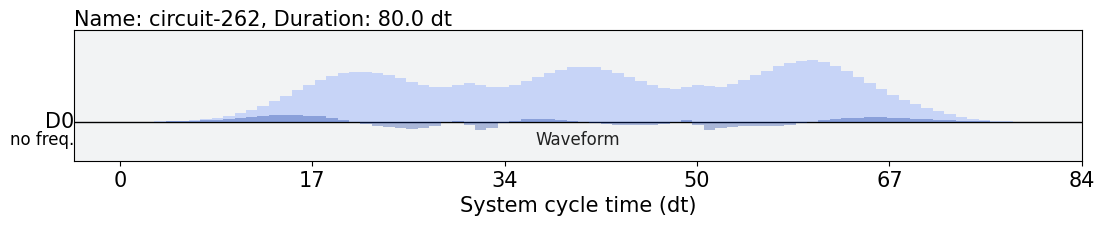

In [11]:
qc = get_circuit(
    initial_state="0",
    waveforms=waveforms,
    observable='Z',
    backend=backend,
    q_idx=0,
    add_pulse=True,
    change_basis=False,
    add_measure=False,
    enable_MCMD=False,
)

schedule(qc, backend).draw()

In [12]:
qpt = ProcessTomography(qc, backend=backend, physical_qubits=[0])

In [13]:
job = qpt.run(backend=backend)

In [14]:
qpt_results = job.block_for_results()

In [15]:
# Print results
for res in qpt_results.analysis_results():
    print(res)

AnalysisResult
- name: state
- value: Choi([[ 0.53325 +0.j      ,  0.0565  +0.47525j ,  0.050375+0.480625j,
        0.498625-0.095875j],
      [ 0.0565  -0.47525j ,  0.46675 +0.j      ,  0.438375+0.004375j,
       -0.050375-0.480625j],
      [ 0.050375-0.480625j,  0.438375-0.004375j,  0.4715  +0.j      ,
       -0.0365  -0.478j   ],
      [ 0.498625+0.095875j, -0.050375+0.480625j, -0.0365  +0.478j   ,
        0.5285  +0.j      ]],
     input_dims=(2,), output_dims=(2,))
- quality: unknown
- extra: <11 items>
- device_components: ['Q0']
- verified: False
AnalysisResult
- name: completely_positive
- value: True
- quality: unknown
- extra: <11 items>
- device_components: ['Q0']
- verified: False
AnalysisResult
- name: trace_preserving
- value: False
- quality: unknown
- extra: <11 items>
- device_components: ['Q0']
- verified: False


In [21]:
average_gate_fidelity(qpt_results.analysis_results(0).value, Operator(np.array(unitaries_opt[-1]))), average_gate_fidelity(qpt_results.analysis_results(0).value, Operator(np.array(target_unitary)))

(0.9760666543569619, 0.9752500065167751)

In [24]:
process_fidelity(qpt_results.analysis_results(0).value, Operator(np.array(unitaries_opt[-1]))) #, average_gate_fidelity(qpt_results.analysis_results(0).value, Operator(np.array(target_unitary)))

Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [6.75196152e-07 6.75196152e-07]


0.964099981535443